In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import plotting
from scipy.stats import norm

sns.set_style("whitegrid")
sns.set_context("paper", rc={
    "axes.labelsize": 20,
    "xtick.labelsize": 20
})   

In [3]:
# results = []
# results_dir = './20231005144659_sim_mar/results/'
# for filename in os.listdir(results_dir):
#     with open(f'{results_dir}/{filename}', 'rb') as f:
#         res = pickle.load(f).to_dict()
#         res.update(res['result'])
#         del res['result']
#         results.append(pd.Series(res))

# df = pd.DataFrame(results)
# with open('./20231005144659_sim_mar/results_all.pickle', 'wb') as f:
#     pickle.dump(df, f)

In [2]:
# 20231004145115_sim_mar
# 20231005144659_sim_mar
# 20240201000642_sim_mar

# with open(f'./results/20240130154602_sim_mar/results_all.pickle', 'rb') as f:
with open(f'./results/20240131152645_sim_mar/results_all.pickle', 'rb') as f:
    df_logchol = pickle.load(f)

with open(f'./results/20240201000642_sim_mar/results_all.pickle', 'rb') as f:
    df_ours = pickle.load(f)
    df_ours_w = df_ours[df_ours['sim_setup'] == 'wasserstein'].copy()
    df_ours_r = df_ours[df_ours['sim_setup'] == 'r'].copy()

with open(f'./results/20240201000642_sim_mar/results_all.pickle', 'rb') as f:
    df_ser_dep = pickle.load(f)
    df_ser_dep_w = df_ser_dep[df_ser_dep['sim_setup'] == 'wasserstein'].copy()
    df_ser_dep_r = df_ser_dep[df_ser_dep['sim_setup'] == 'r'].copy()


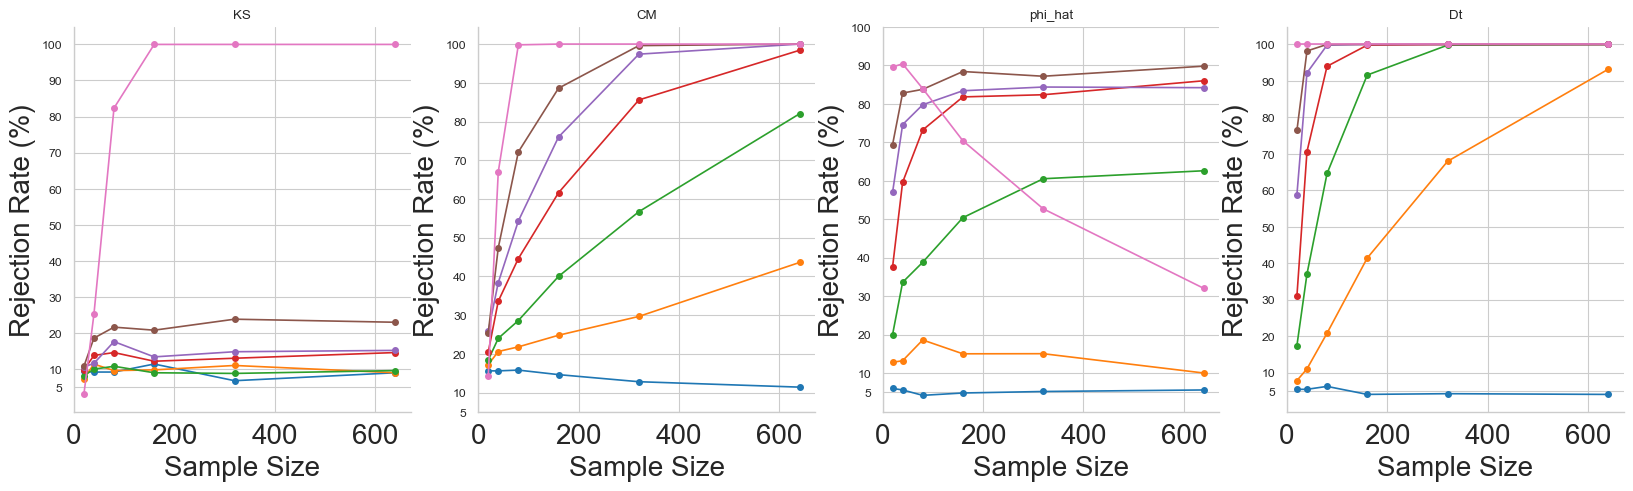

In [3]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_ser_dep_w, 'KS', onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_ser_dep_w, 'CM', onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_ours_w, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_ours_w, 'Dt')

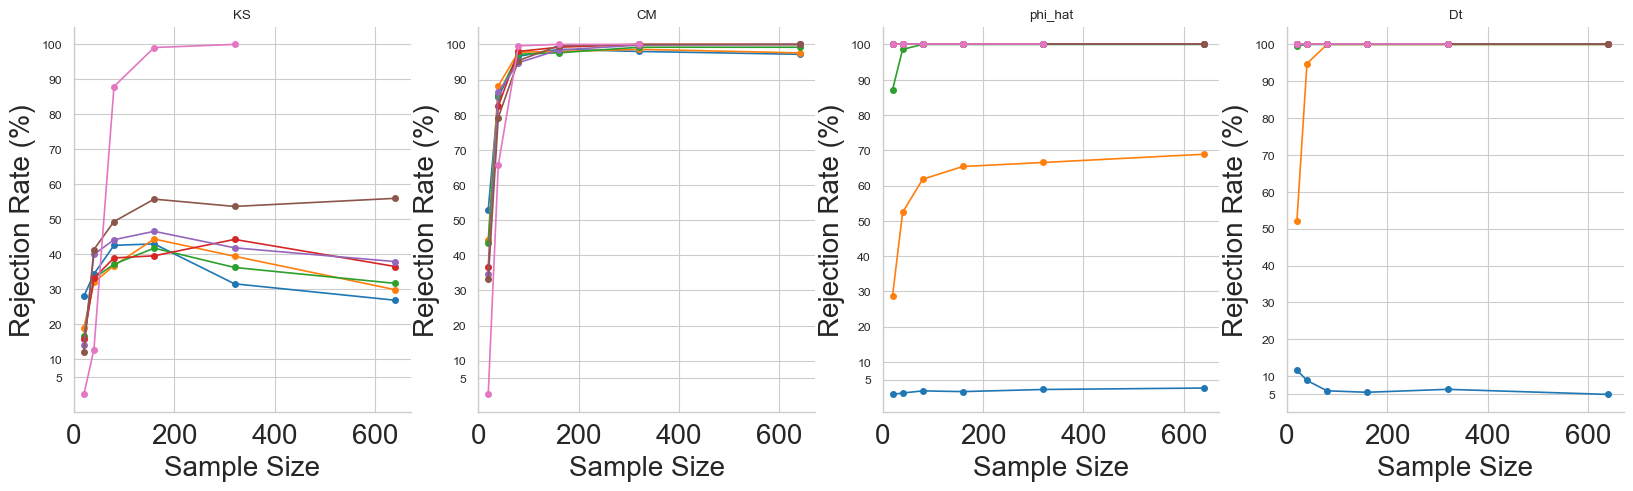

In [4]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_logchol, 'KS', onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_logchol, 'CM', onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_logchol, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_logchol, 'Dt')

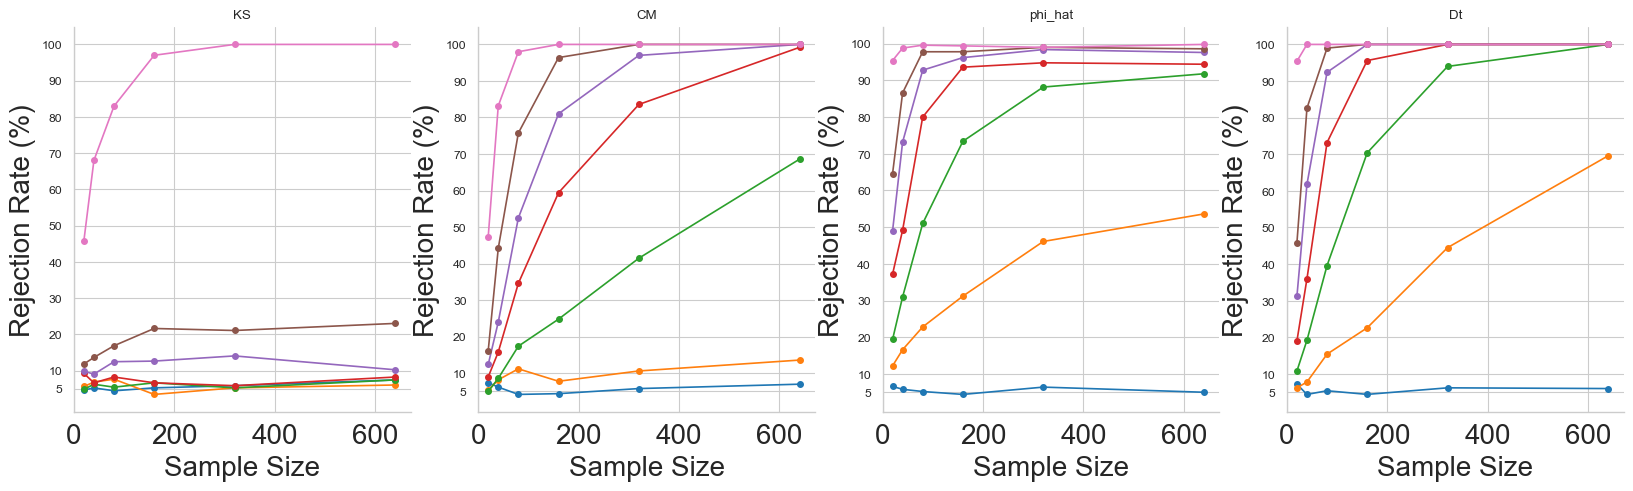

In [5]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_ser_dep_r, 'KS')
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_ser_dep_r, 'CM')


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_ours_r, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_ours_r, 'Dt')

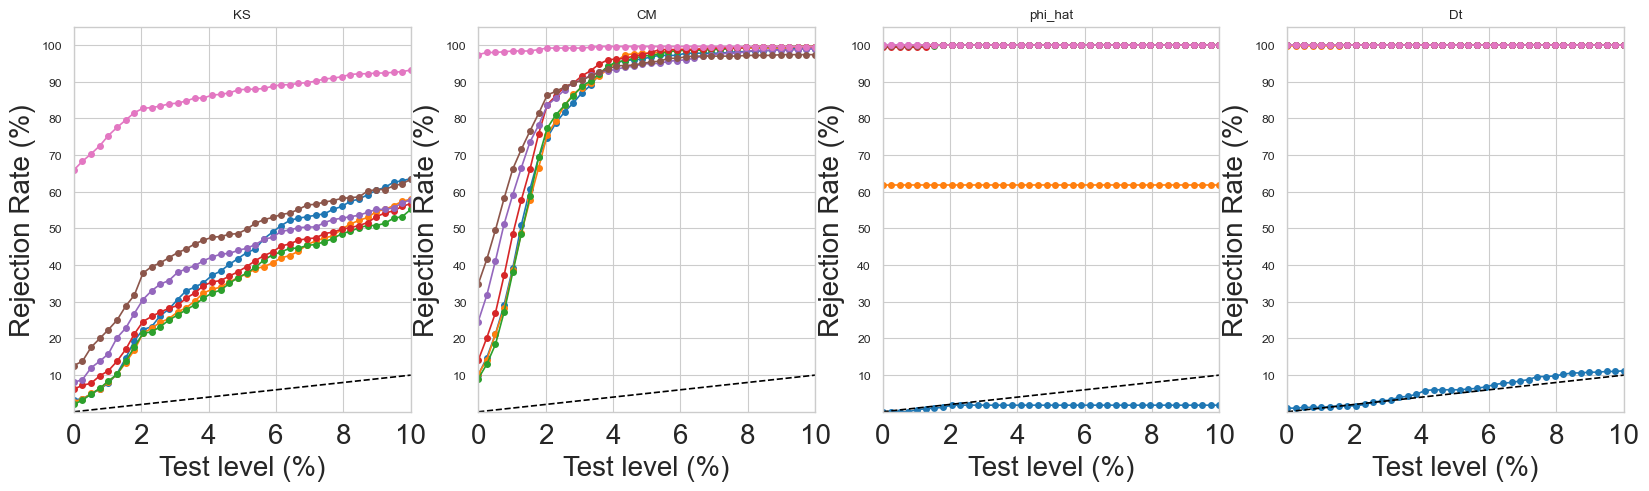

In [134]:

samplesize = 80

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_logchol, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_logchol, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_logchol, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_alpha_alpha(df_logchol, 'Dt', samplesize)


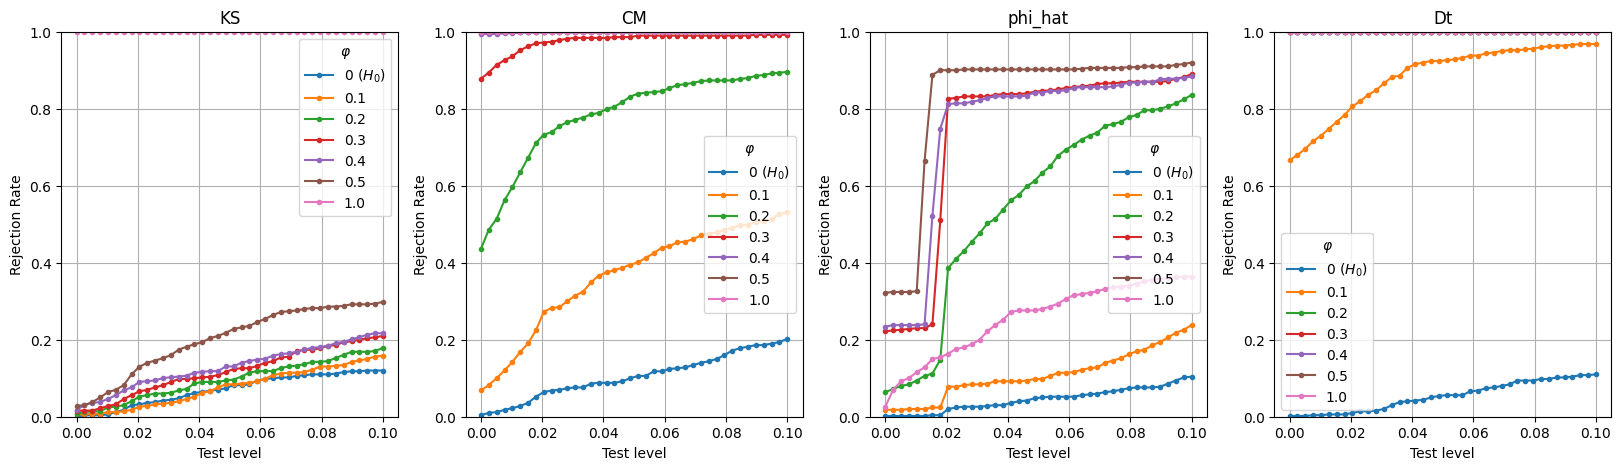

In [66]:

samplesize = 640

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
# plt.plot(np.linspace(0, .1, 40),np.linspace(0, .1, 40))
plotting.plot_alpha_alpha(df_ours_w, 'Dt', samplesize)


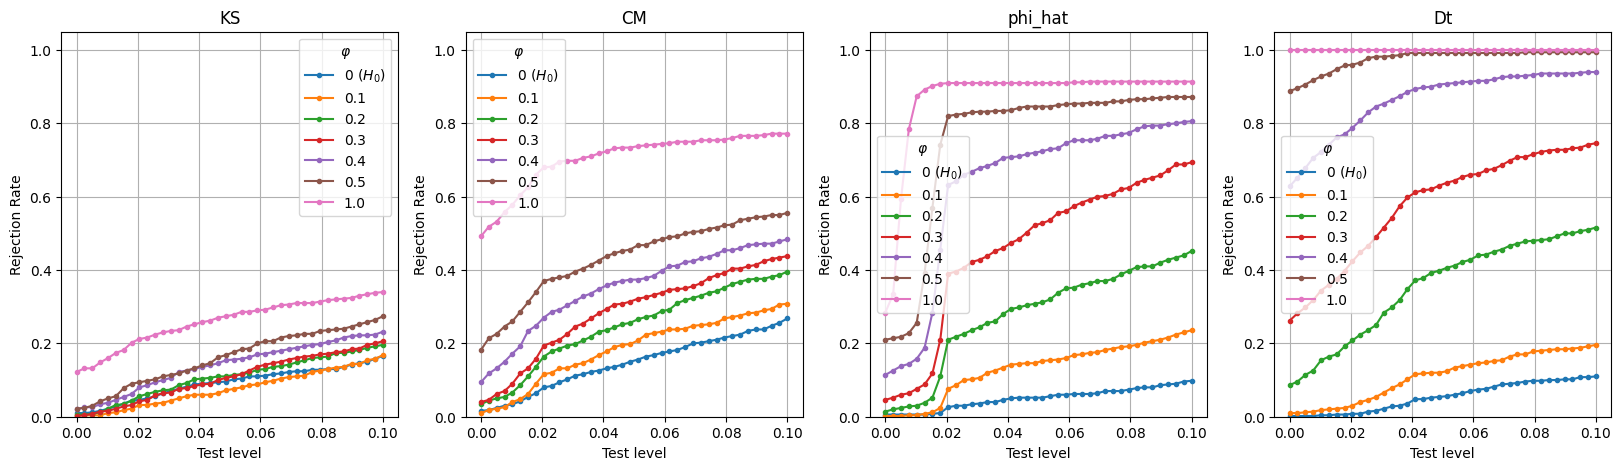

In [68]:
samplesize = 40

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_alpha_alpha(df_ours_w, 'Dt', samplesize)

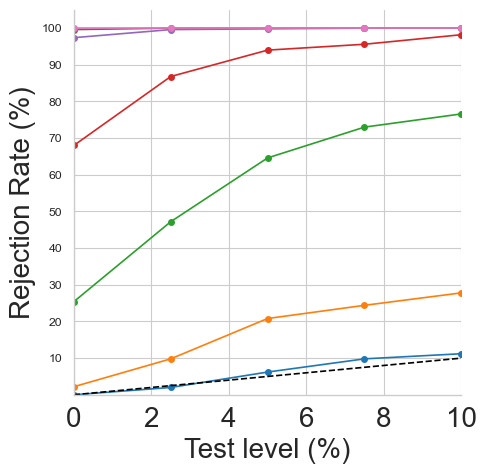

In [13]:
samplesize = 80
plt.figure(figsize=(5,5))
plotting.plot_alpha_alpha(df_ours_w, 'Dt', samplesize)
plt.savefig('./plots/size_rej_rate_wasserstein.pdf', bbox_inches='tight', transparent=True,)

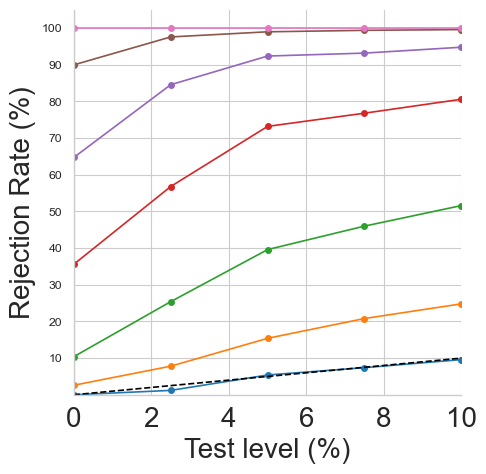

In [14]:
samplesize = 80
plt.figure(figsize=(5,5))
plotting.plot_alpha_alpha(df_ours_r, 'Dt', samplesize)
plt.savefig('./plots/size_rej_rate_R_mult_noise.pdf', bbox_inches='tight', transparent=True,)

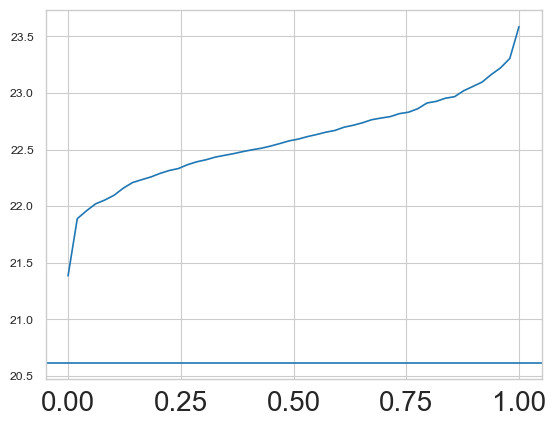

In [16]:
r = df_logchol[(df_logchol['sample_size'] == 80) & (df_logchol['phi'] == 0.1)].iloc[0]

plt.plot(np.linspace(0,1,50), r['quantiles_Dt'])
plt.axhline(r['Dt'])
# r['quantiles_Dt']

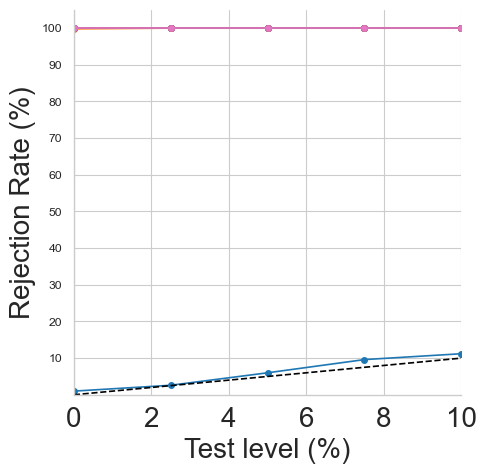

In [3]:
samplesize = 80
plt.figure(figsize=(5,5))
plotting.plot_alpha_alpha(df_logchol, 'Dt', samplesize)
plt.savefig('./plots/size_rej_rate_log_cholesky.pdf', bbox_inches='tight', transparent=True,)

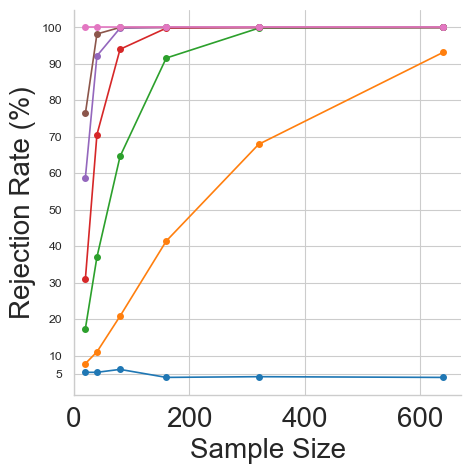

In [240]:
plt.figure(figsize=(5,5))
plotting.plot_test_for(df_ours_w, 'Dt')
plt.savefig('./plots/rejection_rates_wasserstein.pdf', bbox_inches='tight', transparent=True,)

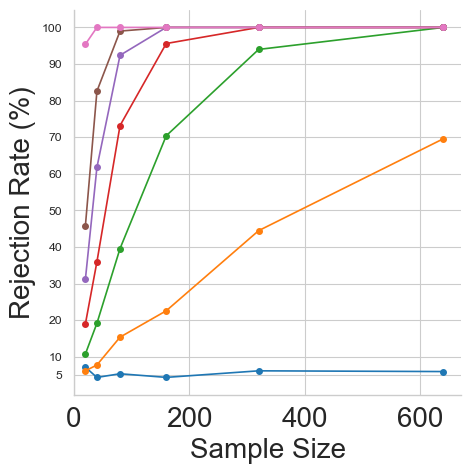

In [241]:
plt.figure(figsize=(5,5))
plotting.plot_test_for(df_ours_r, 'Dt')
plt.savefig('./plots/rejection_rates_R_mult_noise.pdf', bbox_inches='tight', transparent=True,)

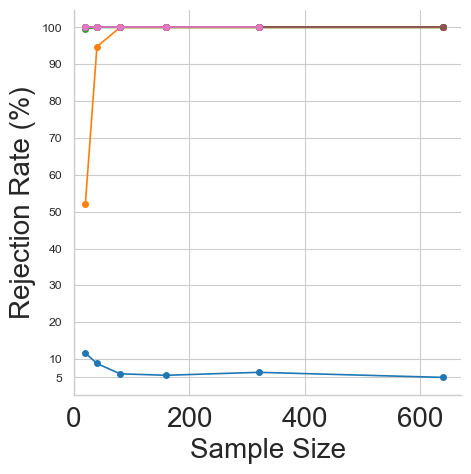

In [242]:
plt.figure(figsize=(5,5))
plotting.plot_test_for(df_logchol, 'Dt')
plt.savefig('./plots/rejection_rates_log_cholesky.pdf', bbox_inches='tight', transparent=True,)

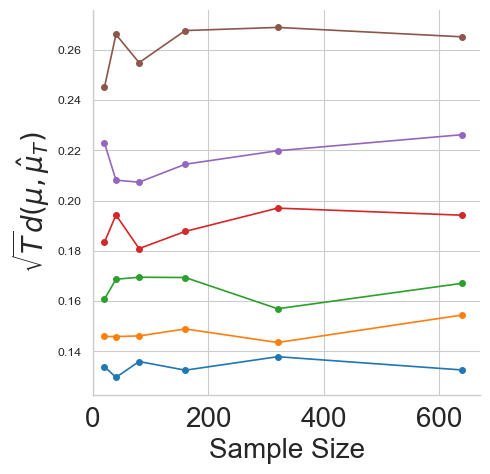

In [236]:
f, ax = plt.subplots(figsize=(5,5))
plotting.plot_sqrt_T_mu(df_ours_w)
plt.savefig('./plots/err_mu_wasserstein.pdf', bbox_inches='tight', transparent=True,)

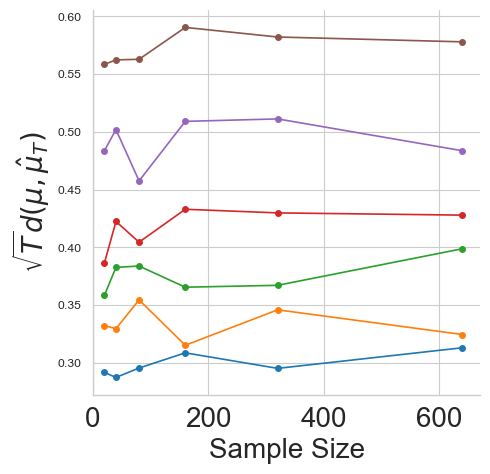

In [237]:
f, ax = plt.subplots(figsize=(5,5))
plotting.plot_sqrt_T_mu(df_ours_r)
plt.savefig('./plots/err_mu_R_mult_noise.pdf', bbox_inches='tight', transparent=True,)

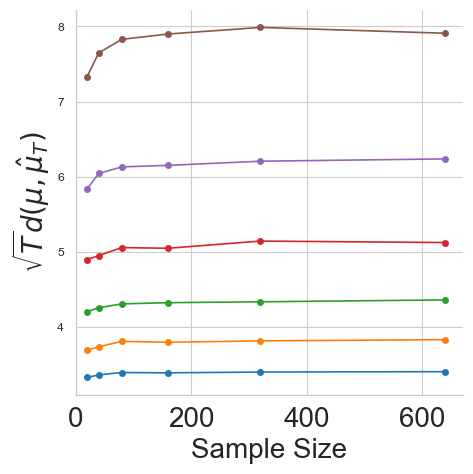

In [238]:
f, ax = plt.subplots(figsize=(5,5))
plotting.plot_sqrt_T_mu(df_logchol)
plt.savefig('./plots/err_mu_logchol.pdf', bbox_inches='tight', transparent=True,)

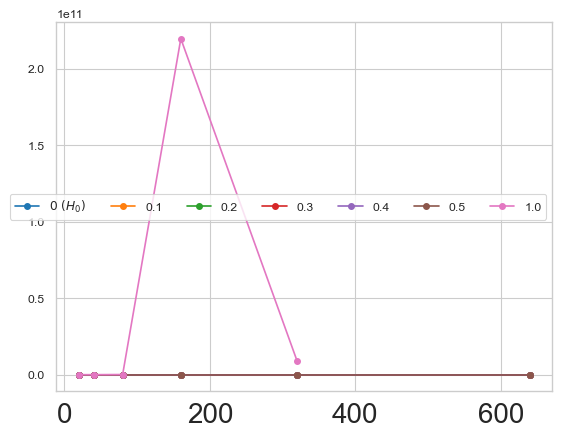

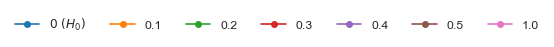

In [230]:
def make_legend(df, expand=[-5,-5,5,5]):
    for phi in np.sort(df.phi.unique()):
        sub_df = df[df['phi'] == phi].copy()
        grped = sub_df.groupby('sample_size').mean(numeric_only=True).reset_index()
        label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
        plt.plot(grped['sample_size'], grped['err'], label=label, marker='o', markersize=4)

    legend = plt.legend(ncols=df.phi.nunique())
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    ax = plt.gca()
    legend_fig, legend_ax = plt.subplots(figsize=(bbox.width, bbox.height))
    legend_squared = legend_ax.legend(
        *ax.get_legend_handles_labels(), 
        bbox_to_anchor=(0, 0, 1, 1),
        bbox_transform=legend_fig.transFigure,
        frameon=False,
        fancybox=None,
        shadow=False,
        ncols=df.phi.nunique(),
        mode='expand',
    )
    legend_ax.axis('off')
    legend_fig.savefig('./plots/legend.pdf', bbox_inches='tight', bbox_extra_artists=[legend_squared], transparent=True,)


make_legend(df_logchol)

In [22]:
min(1,2, 1e-10)

1e-10

Text(0, 0.5, '$\\left|\\hat\\varphi - \\varphi\\right|$')

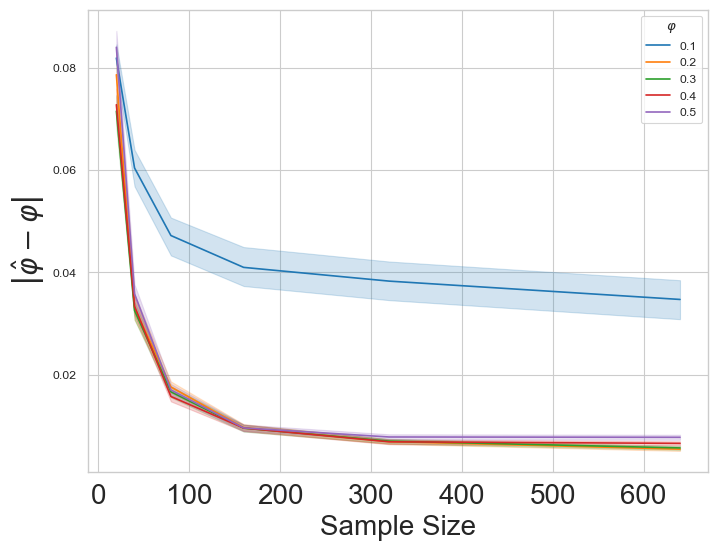

In [16]:
_df = df_logchol

f, ax = plt.subplots(figsize=(8,6))
# ax.set(xscale="log", yscale="log")

for phi in np.sort(_df.phi.unique()):
    if phi == 0 or phi == 1:
        # ax.plot([], [], label=r'$0\ (H_0)$')
        continue
    sub_df = _df[_df['phi'] == phi].copy()
    sub_df['err_phi_hat'] = np.abs(sub_df['phi_hat'] - phi) + 1e-20

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='sample_size', y='err_phi_hat', label=label, ax=ax)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$\left|\hat\varphi - \varphi\right|$')

In [11]:
sub_df

,sample_size,phi,sim_setup,boot_fraction,num_boot,seed,err,phi_hat,Dt,CM,KS,quantiles_Dt,quantiles_phi_hat,quantiles_CM,quantiles_KS
0,80,0.1,r,1,500,3184521958,1.208896e-03,0.134188,0.159836,161.223304,12.152757,"[0.1238395489070141, 0.13904266325352327, 0.14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[139.8455708894176, 146.75919408403436, 147.78...","[10.624916911080106, 11.012010161573324, 11.09..."
12,640,0.1,r,1,500,3617004760,3.632367e-05,0.096588,0.157748,10360.944989,96.717675,"[0.1507802053351523, 0.15927428746964145, 0.16...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10222.947285924962, 10264.420963050325, 10279...","[95.82382862857719, 95.97096670733188, 96.0416..."
13,20,0.1,r,1,500,2638174881,9.210973e-05,0.345653,0.103988,9.932814,2.810975,"[0.055066595030369946, 0.09438294325906259, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.8418667141924505, 8.262845116288547, 8.3557...","[2.489354814793554, 2.626797232574877, 2.65325..."
21,640,0.1,r,1,500,907537602,2.175980e-04,0.161190,0.153900,10750.719987,99.284716,"[0.1619672028347559, 0.16818094653363924, 0.16...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10573.90445351839, 10617.78939259407, 10632.9...","[97.1723998834024, 97.55644277404562, 97.71369..."
39,160,0.1,r,1,500,3758702497,7.826851e-05,0.210678,0.158422,783.267765,26.435373,"[0.1537244321626362, 0.16591645534837515, 0.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[741.137825823028, 752.6247336021478, 757.3139...","[24.999851991849475, 25.35564432014832, 25.427..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41947,160,0.1,r,1,500,3702671214,4.692702e-03,0.000000,0.170656,661.816272,23.933328,"[0.14072352542661268, 0.1505375229175078, 0.15...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[627.700163405963, 640.3681486502599, 643.2778...","[23.08214943976241, 23.347656937190536, 23.435..."
41949,40,0.1,r,1,500,2027581273,9.417351e-03,0.000000,0.144637,29.709873,5.094481,"[0.08423330888441145, 0.09987351526584005, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[22.221250324417028, 23.811079123757548, 24.77...","[4.312701608634387, 4.425190358709651, 4.47899..."
41963,320,0.1,r,1,500,1923383324,8.947796e-05,0.133782,0.151986,2542.051630,47.942229,"[0.14364095552805395, 0.1569517425843437, 0.15...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2461.88943940694, 2487.036454608642, 2493.845...","[46.299255780063305, 46.66030092834558, 46.751..."
41976,320,0.1,r,1,500,2551962930,1.162931e-04,0.000000,0.207534,3461.182691,55.508686,"[0.17470575732195964, 0.18931688519587453, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3344.76582024772, 3391.243508857085, 3399.420...","[54.11273281423661, 54.472176079375636, 54.638..."


In [ ]:
target_T = 100
true_size = np.linspace(0, 1, 40)

for phi in np.sort(_df['phi'].unique()):
    sub_df = _df[(_df['sample_size'] == target_T) & (_df['phi'] == phi)].copy()
    _M = sub_df.shape[0]

    rejection_rate = (np.repeat((np.abs(sub_df['Dt'] - sub_df['boot_mean_Dt']) / sub_df['boot_sig_Dt']).values,true_size.shape[0]).reshape((true_size.shape[0], _M)) > np.repeat(norm.ppf(1 - true_size/2), _M).reshape((true_size.shape[0], _M))).mean(axis=1)

    crit_Dt_lo = compute_critical_val(_df, 'quantiles_Dt', alpha/2)
    crit_Dt_hi = compute_critical_val(_df, 'quantiles_Dt', 1 - alpha/2)

    _df['rejected'] = (_df.Dt < crit_Dt_lo) | (_df.Dt > crit_Dt_hi)


    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    plt.scatter(true_size, rejection_rate, label=label, s=5)
plt.legend(title=r'$\varphi$')
plt.xlabel('Test level')
plt.ylabel('Empirical size')
plt.grid('on')


KeyError: 'boot_mean_Dt'